In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


plt.rcParams['figure.figsize'] = (20,8)

/home/baptiste/Applications/Env/language-model/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


# Data Import

In [3]:
df_train = pd.read_csv("data/Corona_NLP_train.csv", encoding = "ISO-8859-1")
df_test = pd.read_csv("data/Corona_NLP_test.csv", encoding = "ISO-8859-1")

df_train = df_train[["OriginalTweet", "Sentiment"]]
df_test = df_test[["OriginalTweet", "Sentiment"]]

df_train

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


# Label distribution

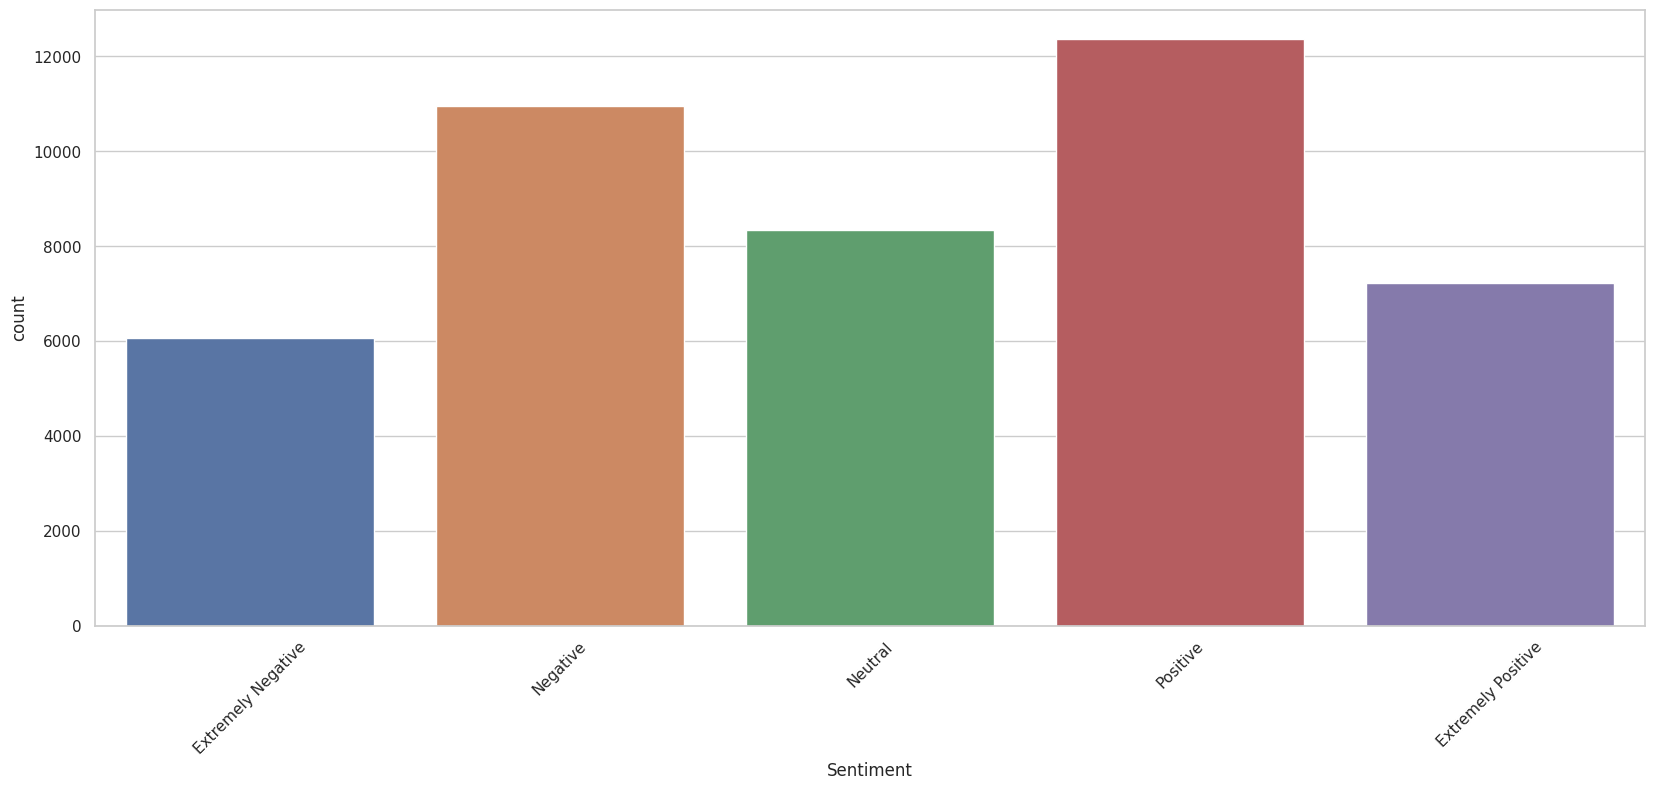

In [4]:
df = pd.concat([df_train, df_test])

sns.countplot(x=df["Sentiment"], order=["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"])
plt.xticks(rotation=45)
plt.show()

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df_train["SentimentEncoded"] = le.fit_transform(df_train["Sentiment"])
df_test["SentimentEncoded"] = le.transform(df_test["Sentiment"])
df_train

,OriginalTweet,Sentiment,SentimentEncoded
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,3
1,advice Talk to your neighbours family to excha...,Positive,4
2,Coronavirus Australia: Woolworths to give elde...,Positive,4
3,My food stock is not the only one which is emp...,Positive,4
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0
...,...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral,3
41153,Response to complaint not provided citing COVI...,Extremely Negative,0
41154,You know itÂs getting tough when @KameronWild...,Positive,4
41155,Is it wrong that the smell of hand sanitizer i...,Neutral,3


# Text Cleaning

In [6]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

tk = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def text_clean(text):
    tokens = tk.tokenize(text)
    
    # lower text
    tokens = [stringliteral.lower() for stringliteral in tokens]
    
    # remove urls
    tokens = [re.sub(r'http\S+', '', stringliteral) for stringliteral in tokens]
    
    # remove @user
    tokens = [re.sub(r'@\S+', '', stringliteral) for stringliteral in tokens]
    
    # remove number
    tokens = [re.sub(r'[0-9]*', '', stringliteral) for stringliteral in tokens]
    
    tokens = [lemmatizer.lemmatize(stringliteral) for stringliteral in tokens]
    
    # remove stop_words
    tokens = list(filter(lambda word: word not in stop_words, tokens))
    
    # remove None 
    tokens = list(filter(None, tokens))
    
    return " ".join(tokens)
    
df_train["OriginalTweet"] = df_train["OriginalTweet"].apply(text_clean)
df_test["OriginalTweet"] = df_test["OriginalTweet"].apply(text_clean)
df_train["OriginalTweet"].head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/baptiste/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/baptiste/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/baptiste/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                                     
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia : woolworth give elderly...
3    food stock one empty ... please , panic , enou...
4    , ready go supermarket #covid outbreak . i'm p...
Name: OriginalTweet, dtype: object

# Vectorizer learning

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 2500)

vectorizer.fit(df["OriginalTweet"])

TfidfVectorizer(max_features=2500)

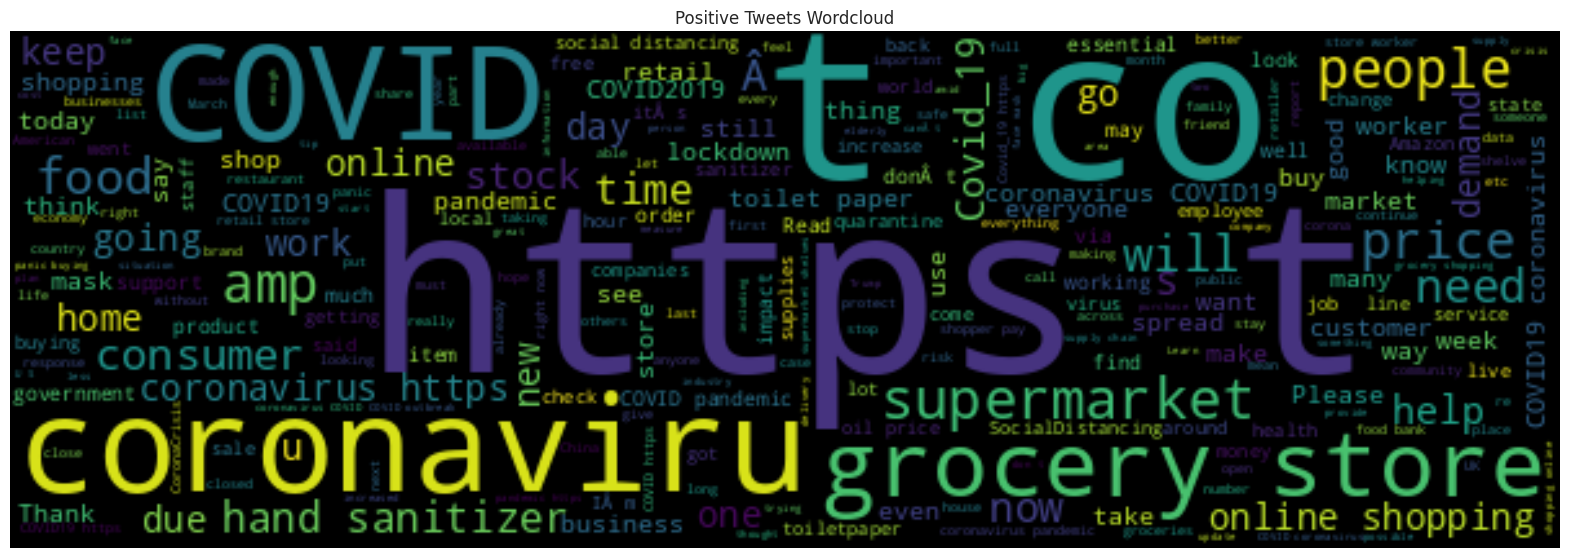

In [8]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=1500, width=600, background_color='black') \
    .generate(" ".join(df[df["Sentiment"]=="Positive"]["OriginalTweet"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Positive Tweets Wordcloud")
plt.axis("off")
plt.show()

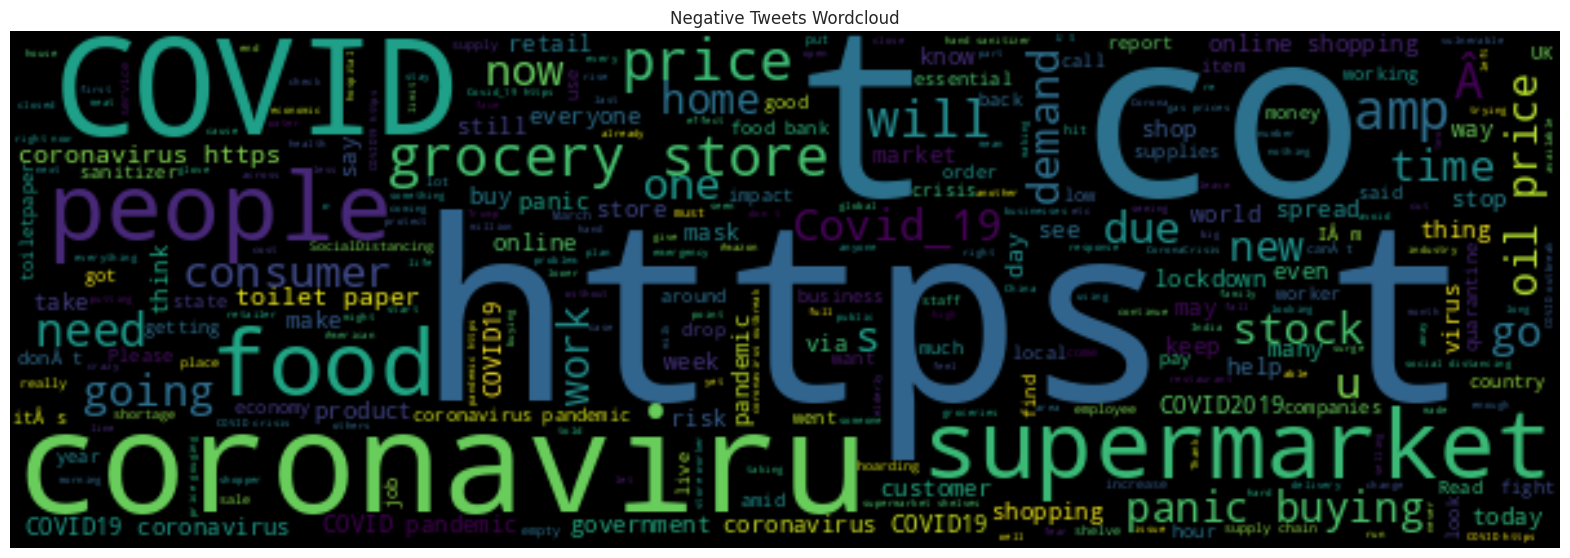

In [9]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=1500, width=600, background_color='black') \
    .generate(" ".join(df[df["Sentiment"]=="Negative"]["OriginalTweet"]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Negative Tweets Wordcloud")
plt.axis("off")
plt.show()

Lexique train

In [10]:
input_dim = len(vectorizer.get_feature_names_out())
output_dim = len(df_train["Sentiment"].unique())

In [11]:
df_train

,OriginalTweet,Sentiment,SentimentEncoded
0,,Neutral,3
1,advice talk neighbour family exchange phone nu...,Positive,4
2,coronavirus australia : woolworth give elderly...,Positive,4
3,"food stock one empty ... please , panic , enou...",Positive,4
4,", ready go supermarket #covid outbreak . i'm p...",Extremely Negative,0
...,...,...,...
41152,airline pilot offering stock supermarket shelf...,Neutral,3
41153,response complaint provided citing covid - rel...,Extremely Negative,0
41154,know itâ  getting tough rationing toilet pape...,Positive,4
41155,wrong smell hand sanitizer starting turn ? #co...,Neutral,3


In [12]:
from torch.utils.data import Dataset, DataLoader

class CoronaDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.tweets = df["OriginalTweet"]
        self.sentiments = df["SentimentEncoded"]
        self.vectorizer = vectorizer
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        sentiment = self.sentiments[idx]
        
        tweet = self.vectorizer.transform([tweet])
        
        return tweet.toarray(), sentiment

train_dataset = CoronaDataset(df_train, vectorizer)
test_dataset = CoronaDataset(df_train, vectorizer)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [13]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 2048, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(2048, 512, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(512, output_dim, dtype=torch.float64),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

Epoch 1


100%|██████████| 644/644 [00:21<00:00, 29.51it/s]


Epoch 2


100%|██████████| 644/644 [00:21<00:00, 30.54it/s]


Epoch 3


100%|██████████| 644/644 [00:21<00:00, 30.40it/s]


Epoch 4


100%|██████████| 644/644 [00:21<00:00, 29.85it/s]


Epoch 5


100%|██████████| 644/644 [00:21<00:00, 29.82it/s]


Epoch 6


100%|██████████| 644/644 [00:21<00:00, 30.08it/s]


Epoch 7


100%|██████████| 644/644 [00:20<00:00, 30.97it/s]


Epoch 8


100%|██████████| 644/644 [00:20<00:00, 30.73it/s]


Epoch 9


100%|██████████| 644/644 [00:21<00:00, 30.42it/s]


Epoch 10


100%|██████████| 644/644 [00:21<00:00, 29.66it/s]


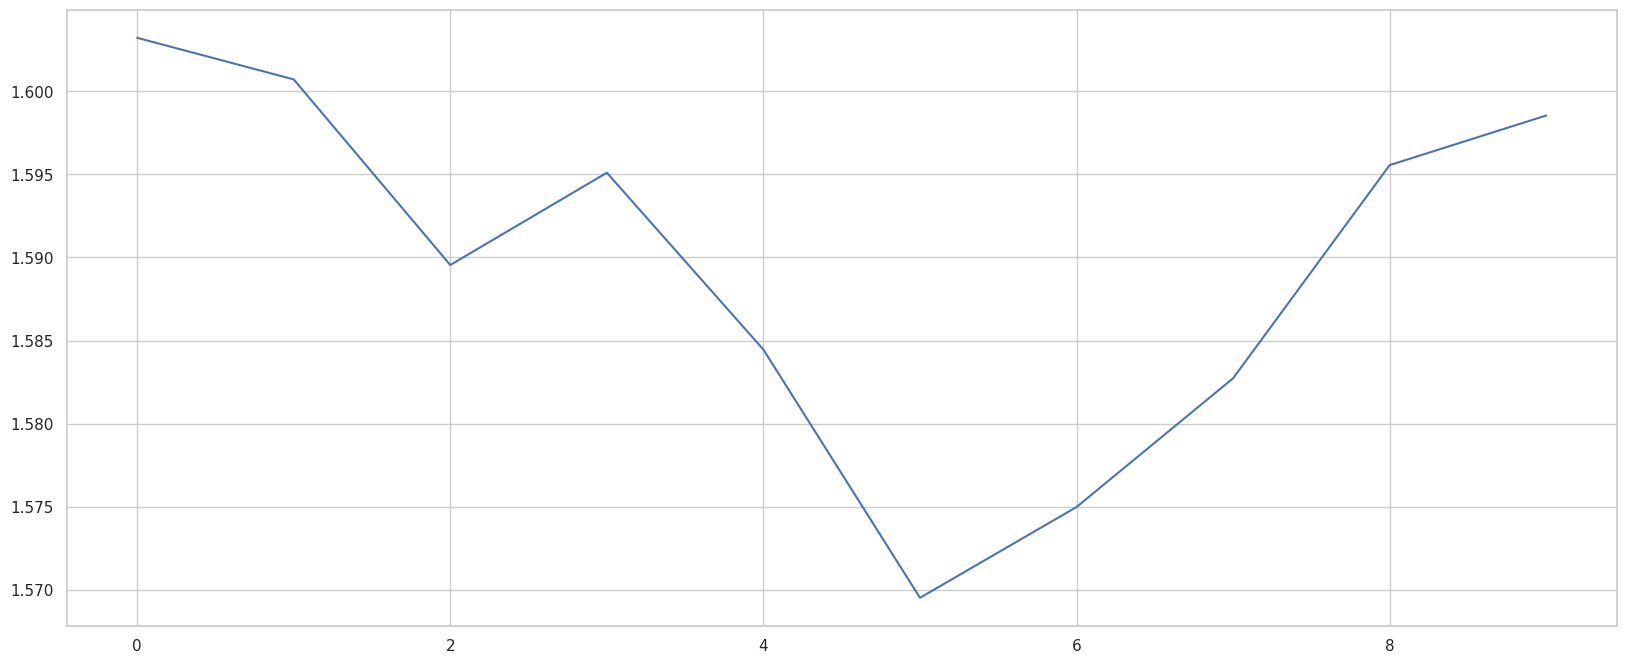

In [14]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


learning_rate = 1e-3
batch_size = 128
epochs = 10

model = NeuralNetwork(input_dim, output_dim).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    losses = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            losses.append(loss)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return losses

all_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}")
    losses = train_loop(train_dataloader, model, loss_fn, optimizer)
    mean_loss = sum(losses)/len(losses)
    
    all_losses.append(mean_loss)
    
plt.plot(all_losses)

In [15]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        outputs = np.array([])
        labels = np.array([])
        for X, y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred.squeeze(), y).item()
            outputs = np.append(outputs, pred.squeeze().argmax(1).cpu().numpy())
            labels = np.append(labels, y.cpu().numpy())
            
            correct += (pred.squeeze().argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return outputs, labels

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred, y_true = test_loop(test_dataloader, model, loss_fn)
y_pred_label = le.inverse_transform(y_pred.astype(np.int32))
y_true_label = le.inverse_transform(y_true.astype(np.int32))

cf = confusion_matrix(y_pred_label, y_true_label)
ConfusionMatrixDisplay(cf).plot()

100%|██████████| 644/644 [00:27<00:00, 23.67it/s]


Test Error: 
 Accuracy: 27.8%, Avg loss: 1.576276 



ValueError: y should be a 1d array, got an array of shape () instead.

# Save models

In [33]:
torch.save(model.to("cpu"), "models/neuralnetwork.pth")
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'Extremely Negative': 0,
 'Extremely Positive': 1,
 'Negative': 2,
 'Neutral': 3,
 'Positive': 4}